## Import necessary packages

In [1]:
from utils.data_utils import lagged_matrix
import h5py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from scipy.stats import pearsonr

## Load & examine data for one of the participants

In [2]:
participant = 9 # there are 13 participants in total
story_part = 0 # there are 15 story parts in total

with h5py.File('../data/data.h5') as f:
    eeg = f[f'eeg/P0{participant}/part{story_part}'][:]
    env = f[f'stim/part{story_part}'][:]

The sampling rate of both the EEG and the speech envelope is 125 Hz here. The EEG have been bandpass filtered between 0.5 and 8 Hz. We normally highpass the filter the EEG above 0.5 Hz to remove slow difts in the EEG signals. The EEG was lowpassed because most of the energy of the speech envelope is contained below 8 Hz.

Text(0.5, 1.0, 'EEG PSD')

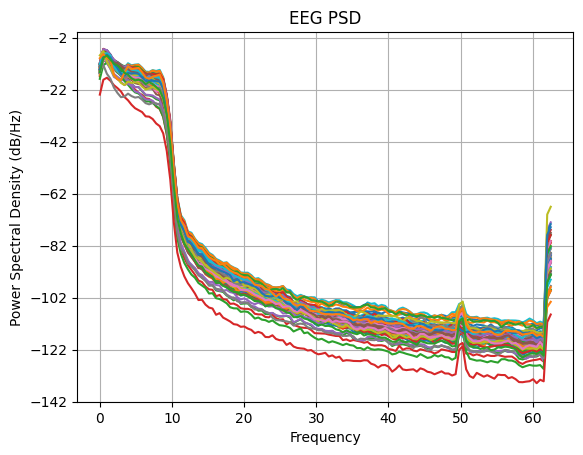

In [3]:
for i in range(63):
    plt.psd(eeg[i], Fs=125);

plt.title('EEG PSD')

The envelope has not been filtered. I calculated the envelope by taking the absolute value of the hilbert transform of the raw speech waveform. I then downsampled this to 125 Hz:

Text(0.5, 1.0, 'First 10s of speech envelope')

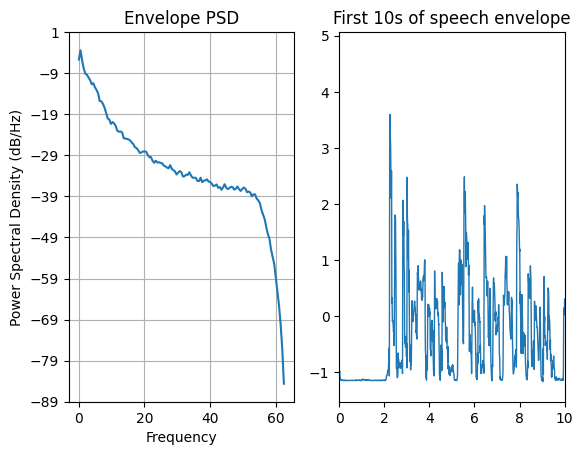

In [4]:
fig, axs = plt.subplots(1,2)

axs[0].psd(env, Fs=125);
axs[0].set_title('Envelope PSD')

n_samples = np.size(env)
times = np.arange(n_samples)/125
axs[1].plot(times, env, lw=1)
axs[1].set_xlim(0,10)
axs[1].set_title('First 10s of speech envelope')

# Prepare data to fit a forward model

We are going to fit a forward model for one of the participants. We are going to load and concatenate all 15 story parts for that participants

In [5]:
participant = 9# there are 13 participants in total

with h5py.File('../data/data.h5') as f:
    train_eeg = [f[f'eeg/P0{participant}/part{i}'][:].T for i in range(9)]
    train_env = [f[f'stim/part{i}'][:] for i in range(9)]
    
    test_eeg = [f[f'eeg/P0{participant}/part{i}'][:].T for i in range(9,15)]
    test_env = [f[f'stim/part{i}'][:] for i in range(9,15)]
    
train_eeg = np.vstack(train_eeg)
train_env = np.hstack(train_env)[:, np.newaxis]
    
test_eeg = np.vstack(test_eeg)
test_env = np.hstack(test_env)[:, np.newaxis]

Next, form the lagged stimulus matrix (more on this later)

In [6]:
env_lags = np.arange(-20, 50)
train_env_lagged = lagged_matrix(train_env, env_lags)
test_env_lagged = lagged_matrix(test_env, env_lags)

Now we will fit the ridge regression and look at how well each channel was reconstructed:

In [7]:
mdl = Ridge(alpha=1e4)
mdl.fit(train_env_lagged, train_eeg)

predictions = mdl.predict(test_env_lagged)

for channel in range(63):
    print(pearsonr(predictions[:,channel], test_eeg[:,channel])[0])

0.1358870389601714
0.13556611084860007
0.10900263804867817
0.09685885049215731
0.11482674531300692
0.13025973951219255
0.12388607993196957
0.12548337282649064
0.12510478658298316
0.05655667999972071
0.0769285252482653
0.07695206434115215
0.0855478692477689
0.04913685175855504
0.08314594025914478
0.011274259041348142
0.08141250209204075
0.1300354386719901
0.15453594348175767
0.1617928372825615
0.1491042459625056
0.1713677424949196
0.1638819068100605
0.15924341722221544
0.11914791051178635
0.14274942413938133
0.15443619591231475
0.16083762712125693
0.15591445750322197
0.16317680118524341
0.10733637767811645
0.12787509439572736
0.09077827580147795
0.0992041045179545
0.03156968914365048
0.12813752534263617
0.09534113777312735
0.02676628290768172
0.15570344099087208
-0.005725879963592696
0.02905278624678824
0.010850250652740747
0.03306378959831824
0.03895603897599703
0.029148837914789144
0.034588163250374566
0.05424550381894596
0.047738944818615334
0.05735471025979923
0.06445249703297234
0.

# plot the coefficients of the linear model:

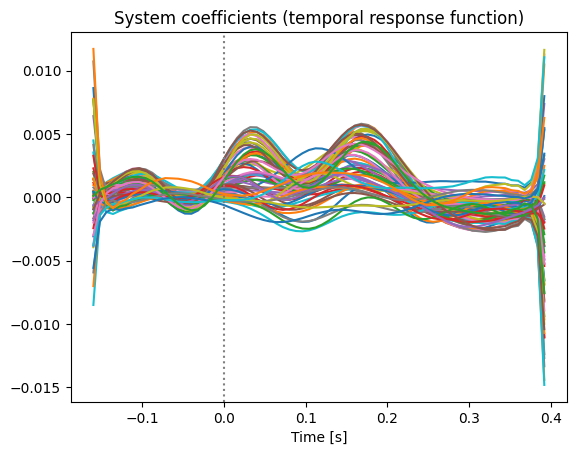

In [8]:
plt.plot(env_lags/125,mdl.coef_.T);
plt.title('System coefficients (temporal response function)')
plt.xlabel('Time [s]')
plt.axvline(0, color='grey', linestyle='dotted')

## what is the 'lagged stimulus matrix'?

The lagged stimulus matrix simply contains columns which are time-lagged versions of the original time series:

In [9]:
print(train_env[:5,0], '\n')
print(train_env_lagged[:5, 0])
print(train_env_lagged[:5, 1])
print(train_env_lagged[:5, 2])
print(train_env_lagged[:5, 3])

[-1.02203505 -1.02300686 -0.97912907 -0.97928775 -1.07653109] 

[-1.14308907 -1.13940185 -1.14554688 -1.14327356 -1.14804201]
[-1.14482677 -1.14308907 -1.13940185 -1.14554688 -1.14327356]
[-1.14409518 -1.14482677 -1.14308907 -1.13940185 -1.14554688]
[-1.14451103 -1.14409518 -1.14482677 -1.14308907 -1.13940185]


# Fit a backward model

In [16]:
eeg_lags = np.arange(-50, 20)
train_eeg_lagged = lagged_matrix(train_eeg, eeg_lags)
test_eeg_lagged = lagged_matrix(test_eeg, eeg_lags)

In [17]:
backward_mdl = Ridge(alpha=1e4)
backward_mdl.fit(train_eeg_lagged, train_env)

Ridge(alpha=10000.0)

In [18]:
predictions = backward_mdl.predict(test_eeg_lagged)
print(pearsonr(predictions.squeeze(), test_env.squeeze())[0])

0.3573382506466833
